In [109]:
#all imports
import math as m
import numpy as np
import pandas as pd
import copy
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import os
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

In [110]:
#Point and Defect Classes
 

class Points():
    '''class that holds information about the di/dv point scans'''
    
    def __init__(self, params):
        self.name = params[0]
        self.x = int(params[5])
        self.y = int(params[6])
        self.pos = (self.x,self.y)
        self.x_drift = int(params[3])
        self.y_drift = int(params[4])
        self.group = params[7]
        self.explosion = params[8]
        self.graph = True

        if params[9] == "minimal":     #there is almost no noise
            self.noise = 0
        elif params[9] == "little":    #there is some noise, but not in the areas where I see peaks
            self.noise = 1
        elif params[9] == "a bit":     #there is some noise and could affect the peaks a little
            self.noise = 2
        else:
            self.noise = 3             #there is noise, but barely not enough for me to ignore the results

        self.pot_diff = (float(params[10]),float(params[11]))
        self.peaks = {}

        leftovers = params[12::]
        for i in leftovers:
            if i != '':
                self.peaks[float(i)] = True
        
        #data I collected but did not think pertinent for data visualization
        #to use later when implementing a data submission form
        #self.x_original = params[1]     
        #self.y_original = params[2]
        #self.x_drift
        #self.y_drift

    def __repr__(self):
        return "Point " + self.name + " at position " + str(self.pos) + " with peaks " + str(self.peaks)
    
    def __str__(self):
        return "Point " + self.name
    
    def info(self):
        print( self.name + "\n" + "Position: " + str(self.pos) + '\n' + "Peaks: " + str(self.peaks) + '\n' + "Drift(x,y): " + '(' + str(self.x_drift) +','+ str(self.y_drift) + ')' + "   Noise level: " +str(self.noise) + "\n" + "Potential difference: " + str(self.pot_diff) + '\n' + "Explosion: " + self.explosion + "   Group: " + self.group + '\n' )
        return
    
    def __sub__(self,other):          #for distance between points
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    

class Defect():
    '''class to identify defects, also allows for distances beteen points and defects'''
    
    def __init__(self,params):
        self.name = params[0]
        self.x = int(params[1])
        self.y = int(params[2])
        self.pos = (self.x,self.y)

    def __sub__(self,other):          #for distance between point and the defect, for specific range graphing
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name + " at position " + str(self.pos)


In [111]:
#big shoutout for visualize3DData found here: https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
#contains code for hover effect and plot specifics

def visualize3DData (x,y,z,wy,num):
    """Visualize data in 3d plot with popover next to mouse position.

    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
    Returns:
        None
    """
    fig = plt.figure(figsize = (11,7))
    ax = fig.add_subplot(111, projection = '3d')
    Y = wy
    #depending on type of graph, adjust the figure accordingly
    if num == 1:
        X = np.transpose(np.array([y,x,z]))
        ax.scatter(y,x,z, picker = True)
        plt.title('di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif num == 2:
        X = np.transpose(np.array([x,y,z]))
        ax.scatter(x,y,z, 'z',c = z, cmap=plt.cm.jet) #spring,viridis,plasma,jet
        plt.title('Color di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif num == 3:
        X = np.transpose(np.array([y,x,z]))
        plt.title('di/dv Peaks - Top View')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        ax.scatter(y,x,z)
        ax.azim = 0 #0 for x view, -90 for y view
        ax.elev = -90 #-90 for top view
        fig.set_size_inches(8.5,16.5)
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif num == 4:
        X = np.transpose(np.array([y,x,z]))
        plt.title('di/dv Peaks -  y Side View')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        ax.scatter(y,x,z)
        ax.azim = -90 #0 for x view, -90 for y view
        ax.elev = 0 #-90 for top view
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif num == 7:
        X = np.transpose(np.array([y,x,z]))
        plt.title('di/dv Peaks -  x Side View')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        ax.scatter(y,x,z)
        ax.azim = 0 #0 for x view, -90 for y view
        ax.elev = 0 #-90 for top view
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif num == 5:
        X = np.transpose(np.array([y,x,z]))
        plt.title('Color di/dv Peaks -  y Side View')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        ax.scatter(y,x,z, 'z',c = z, cmap=plt.cm.jet)
        ax.azim = -90 #0 for x view, -90 for y view
        ax.elev = 0
        ax.legend(fontsize='small')
    elif num == 6:
        X = np.transpose(np.array([y,x,z]))
        plt.title('Color di/dv Peaks -  Top View')
        fig.set_size_inches(8.5,16.5)
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        ax.scatter(y,x,z, 'z',c = z, cmap=plt.cm.jet)
        ax.azim = 0 #0 for x view, -90 for y view
        ax.elev = -90
        ax.legend(fontsize='small')
    elif num == 8:
        X = np.transpose(np.array([y,x,z]))
        plt.title('Color di/dv Peaks -  x Side View')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        ax.scatter(y,x,z, 'z',c = z, cmap=plt.cm.jet)
        ax.azim = 0 #0 for x view, -90 for y view
        ax.elev = 0
        ax.legend(fontsize='small')
    
    
    def calcClosestDatapoint(X, event):
        """"Calculate which data point is closest to the mouse position.

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (X[i, 0:3], event) for i in range(X.shape[0])]
        return np.argmin(distances)
    
    
    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (3,), "distance: point.shape is wrong: %s, must be (3,)" % point.shape

        # Project 3d data space to 2d data space
        x2, y2, _ = proj3d.proj_transform(point[0], point[1], point[2], plt.gca().get_proj())
        # Convert 2d data space to 2d screen space
        x3, y3 = ax.transData.transform((x2, y2))

        return np.sqrt ((x3 - event.x)**2 + (y3 - event.y)**2)

    def annotatePlot(X, index, Y):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        titel = wy[int(index)]
        # If we have previously displayed another label, remove it first
        if hasattr(annotatePlot, 'label'):
            annotatePlot.label.remove()
        # Get data point from array of points X, at position index
        x2, y2, _ = proj3d.proj_transform(X[index, 0], X[index, 1], X[index, 2], ax.get_proj())
        annotatePlot.label = plt.annotate( "%s" % titel,
            xy = (x2, y2), xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'orange', alpha = 0.5), #fc is the color of the hover pop up bubble
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        fig.canvas.draw()


    def onMouseMotion(event):
        """Event that is triggered when mouse is moved. Shows text annotation over data point closest to mouse."""
        closestIndex = calcClosestDatapoint(X, event)
        annotatePlot (X, closestIndex,Y)
        
    fig.canvas.mpl_connect('motion_notify_event', onMouseMotion)  # on mouse motion
    plt.show()
    return

In [112]:
#Graph Class


class Graph():
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __init__(self,params):
        self.name = params[0]
        self.samples = params[1]
        self.graph_num = 0
        #to keep track of refinement filters, otherwise undoing a filter get's complicated
        self.refine_list = {'noise':[False],'position':[False],'explode':[False],'peaks':[False]}
        self.defects = []
        #eps files not currently kept track of in this file, but code from show_eps.ipynb works in this program
        self.locks = []
        self.currents = []   
    
    def scatter3(self):
        '''Scatter plot of the paramater list'''
        #graph number set so that when filters are applied, they affect the current graph selection
        self.graph_num = 1

        x = []
        y = []
        z = []
        Y = []
        
        #separate x,y,z coordinates for ax plotting in visualize function, also keep track of the point name
        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        Y.append(point.name)
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)
        
        visualize3DData (x,y,z,Y,self.graph_num)
        return

    def scatter_color(self):
        '''Color scatter plot'''
        self.graph_num = 2

        x = []
        y = []
        z = []
        Y = []
        
        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        Y.append(point.name)
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)
        
        visualize3DData (x,y,z,Y,self.graph_num)
        return

    def scatter_angle(self, rotation, elevation):
        '''Scatter plot at different angles, preset in graphing buttons'''
        #set the rotation to specific angles, but can be used if needed for other angles and elevations 
        if rotation == 0 and elevation == -90:
            self.graph_num = 3
        if rotation == -90 and elevation == 0:
            self.graph_num = 4
        if rotation == 0 and elevation == 0:
            self.graph_num = 7

        x = []
        y = []
        z = []
        Y = []

        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        Y.append(point.name)
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)
        
        visualize3DData (x,y,z,Y,self.graph_num)
        return

    def scatter_color_angle(self, rotation, elevation):
        '''scatter plot at angles with color'''
        #earlier versions were more different, could be combined with scatter_angle in future iterations
        if rotation == -90 and elevation == 0:
            self.graph_num = 5
        if rotation == 0 and elevation == -90:
            self.graph_num = 6
        if rotation == 0 and elevation == 0:
            self.graph_num = 8

        x = []
        y = []
        z = []
        Y = []
        
        for point in self.samples:
            if point.graph == True:
                Y.append(point.name)
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)

        visualize3DData (x,y,z,Y,self.graph_num)
        return
    
    #Data refinement functions, go through the sample list and check against samples that have not already been filtered out
    
    def noise(self,noise):
        for point in self.samples:
            if point.graph == True:
                if point.noise <= noise:
                    point.graph = True
                else:
                    point.graph = False
        return

    def explode(self, explosion):
        for point in self.samples:
            if point.graph == True:
                if point.explosion == explosion:
                    point.graph = True
                else:
                    point.graph = False
        return

    def position(self, min_val, max_val):
        for point in self.samples:
            if point.graph == True:
                if min_val <= point.y <= max_val:
                    point.graph = True
                else:
                    point.graph = False
        return

    def peaks(self,min_peak,max_peak):
        for point in self.samples:
            if point.graph == True:
                #self.peaks is a dict because each point can have multiple peaks, avoids removing all peaks for a certain point
                for peak in point.peaks:
                    if min_peak < peak < max_peak:
                        point.peaks[peak] = True
                    else:
                        point.peaks[peak] = False
        return

    def reset(self):
        '''resets all peaks to true and clears the refine list'''
        for point in self.samples:
            point.graph = True
            for peak in point.peaks:
                point.peaks[peak] = True
        for ref in self.refine_list:
            self.refine_list[ref] = [False]
        return

#ex: graph_1 = Graph('graph_1',sample_set)    

In [113]:
#Uploads the curent data file, creates a sample set, and graph class

sample_set = []
data_files = []
count = 0

#searches for csv file
for file in glob.glob('*.csv'):
    data_files.append(file)

if len(data_files) > 1:
    print('Data files for analizing; ',data_files, 'which would you like to open')
    while count == 0:
        answer = input("file name: ")
        if answer.endswith('.csv'):
            filename = answer
        else:
            filename = answer + '.csv'
            
        for file in data_files:
            if str(filename) == str(file):
                print('opening ', filename, 'for data visualization')
                with open(filename) as file:
                    for line in file:
                        data = line.strip().split(',')
                        try:
                            if data[0][2] == '_':
                                sample_set.append(Points(data))
                        except:
                            IndexError 
                count = 1
                break
        if count == 0:
            print('unrecognized filename')
                
            
else: 
    print('opening ',data_files[0], 'for data visualization')
    with open(data_files[0]) as file:
        for line in file:
            data = line.strip().split(',')
            try:
                if data[0][2] == '_':
                    sample_set.append(Points(data))
            except:
                IndexError 

#creates our main graph object with our selected data
analysis = Graph(['analysis',sample_set])

opening  Peak_data.csv for data visualization


In [114]:
#Alloted for GUI Back end

from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import display
from IPython.display import clear_output
import warnings
#warnings.filterwarnings('ignore')


#functions to call the choice functions because the button widget does not allow for paramater input

def call_function(sender):     #user input function
    user_input = sender.value
    print(user_input)  
    return

def graph1(val):     #each graph function calls upon a different function of the graph class
    clear_output()
    analysis.scatter3()
    return
    
def graph2(val):
    clear_output()
    analysis.scatter_color()
    return

def graph3(val):
    clear_output()
    analysis.scatter_angle(0,-90)
    return

def graph4(val):
    clear_output()
    analysis.scatter_angle(-90,0)
    return

def graph5(val):
    clear_output()
    analysis.scatter_color_angle(-90,0)
    return

def graph6(val):
    clear_output()
    analysis.scatter_color_angle(0,-90)
    return

def graph7(val):
    clear_output()
    analysis.scatter_angle(0,0)
    return

def graph8(val):
    clear_output()
    analysis.scatter_color_angle(0,0)
    return

def refine1(name,new):
    if new == 'minimal':
        temp = 0
    elif new == 'a little':
        temp = 1
    elif new == 'moderate':
        temp = 2
    else:
        temp = 3
    analysis.refine_list['noise'] = [True,temp]
    return    

def refine2(name,new):
    print('hi')
    if new == 'all':
        temp = 'all'
    elif new == 'before':
        temp = 'pre+'
    else:
        temp = 'post'
    analysis.refine_list['explode'] = [True,temp]
    return

def refine3(sender):
    analysis.refine_list['position'] = [True,int(position_filter.value[0]),int(position_filter.value[1])]
    return

def refine4(sender):
    analysis.refine_list['peaks'] = [True,float(peak_range.value[0]),(peak_range.value[1])]
    return

def refine5(val):
    clear_output()
    num = analysis.graph_num
    
    #refine list is a dictionary, contains four keys.  The first value is True/False, the second and beyond are the paramaters of that filter
    if analysis.refine_list['noise'][0] == True:
        analysis.noise(analysis.refine_list['noise'][1])
    if analysis.refine_list['explode'][0] == True:
        analysis.explode(analysis.refine_list['explode'][1])
    if analysis.refine_list['position'][0] == True:
        analysis.position(analysis.refine_list['position'][1],analysis.refine_list['position'][2])
    if analysis.refine_list['peaks'][0] == True:
        analysis.peaks(analysis.refine_list['peaks'][1],analysis.refine_list['peaks'][2])
  
    if num == 0:
        return
    elif num == 1:
        analysis.scatter3()
    elif num == 2:
        analysis.scatter_color()
    elif num == 3:
        analysis.scatter_angle(0,-90)
    elif num == 4:
        analysis.scatter_angle(-90,0)
    elif num == 5:
        analysis.scatter_color_angle(-90,0)
    elif num == 6:
        analysis.scatter_color_angle(0,-90)
    elif num == 7:
        analysis.scatter_angle(0,0)
    elif num == 8:
        analysis.scatter_color_angle(0,0)
        
    return

def refine6(val):
    clear_output()
    analysis.reset()
    refine5(5)
    return

#for user input selection process
#text = widgets.Text()
#input_field = widgets.Text()
#display(text)
#input_field.on_submit(call_function)

<IPython.core.display.Javascript object>


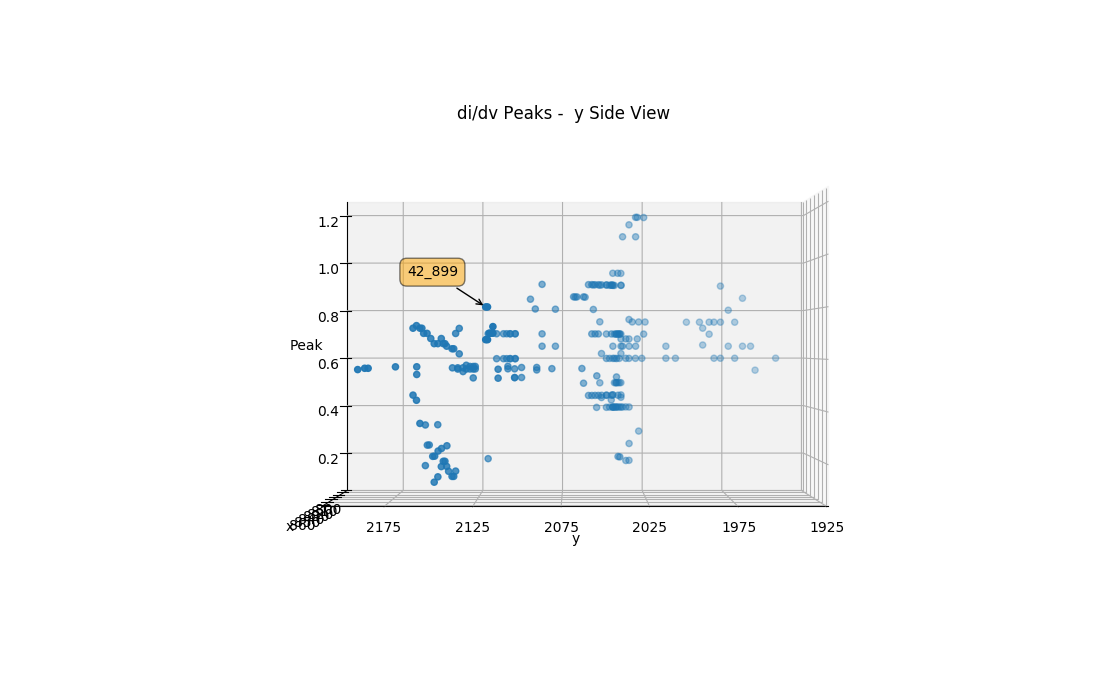

In [115]:
#Alloted for GUI Front End

#Title

#graph buttons
scat3 = widgets.Button(description='Scatter Plot',button_style='info')
scat3c = widgets.Button(description='Color Scatter Plot',button_style='info')
side = widgets.Button(description='Side View',button_style='info')
top = widgets.Button(description='Top View',button_style='info')
sidec = widgets.Button(description='Color Side View',button_style='info')
topc = widgets.Button(description='Color Top View',button_style='info')
sidex = widgets.Button(description='Side View(x)',button_style='info')
sidexc = widgets.Button(description='Color Side View(x)',button_style='info')


#data refinement buttons
apply = widgets.Button(description='Apply Filters',button_style='success')
reset = widgets.Button(description='Reset',button_style='warning')
noise_filter = widgets.Dropdown(options=['all points','moderate','a little','minimal'],description='noise')
pre_post = widgets.Dropdown(options=['all','before','after'],description='Explosion')
position_filter = widgets.IntRangeSlider(value=[800, 2200],min=800,max=2200,step=1,description='Range',continuous_update=True,orientation='horizontal',readout=True,readout_format='i',)
peak_range = widgets.FloatRangeSlider(value=[0, 1.2],min=0,max=1.2,step=.1,description='Peak Range',continuous_update=True,orientation='horizontal',readout=True,readout_format='i',)

#display buttons
display(widgets.HBox((scat3,side,top,sidex)))
display(widgets.HBox((scat3c,sidec,topc,sidexc)))
display(widgets.HBox((noise_filter,pre_post,apply)))
display(widgets.HBox((position_filter,peak_range,reset)))


#button functions
scat3.on_click(graph1)
scat3c.on_click(graph2)
side.on_click(graph4)
top.on_click(graph3)
sidec.on_click(graph5)
topc.on_click(graph6)
sidex.on_click(graph7)
sidexc.on_click(graph8)
reset.on_click(refine6)
apply.on_click(refine5)
noise_filter.on_trait_change(refine1,'value')
pre_post.on_trait_change(refine2,'value')
position_filter.on_trait_change(refine3)
peak_range.on_trait_change(refine4)


#add an apply filter button

In [ ]:
#Point data submission

test_samples = []
def final(data_list,test_list):
    new_point = Points(data_list)
    test_list.append(new_point)
    return

end_call = False
while end_call != True:
    print('Create New Point?','\n')
    answer = input("Yes/No: ")
    if answer == 'Yes':
        clear_output()
        print('Create New Point','\n')
        df = pd.DataFrame(columns=["Data Point Info"])
        questions = ["Point name: ","X drift: ","Y drift: ","X position: ","Y position: ","Group number: ","pre+ or post tip explosion: ","Noise level: ","Potential min: ","Potential max: "]

        for i in range(10):
            dp = input("{}".format(questions[i]))
            df1 = pd.DataFrame(data=[[dp]],columns=["Data Point Info"])
            df = pd.concat([df,df1], axis=0) #this is like +=

        df.index = range(len(df.index))
        
        peaks = []
        print("Input a Peak value or type 'Quit' to finish: ",'\n')
        answer2 = input("Peak value: ")
        while answer2 != 'Quit':
            peaks.append(answer2)
            answer2 = input("Peak value: ")

        print("Is this information correct? ")
        answer3 = input("Yes/No: ")
        while answer3 != 'No':
            if answer3 == "Yes":
                global data
                data = []
                for j in df.values:
                    data.append(j[0])

                final_data = []
                final_data.append(data[0])
                final_data.append('blank')
                final_data.append('blank')
                final_data.append(data[1])
                final_data.append(data[2])
                final_data.append(data[3])
                final_data.append(data[4])
                final_data.append(data[5])
                final_data.append(data[6])
                final_data.append(data[7])
                final_data.append(data[8])
                final_data.append(data[9])
                for k in peaks:
                    final_data.append(k)
                final(final_data,test_samples) 

            elif answer3 == 'No':
                clear_output()
                print("Point aborted")
            else:
                answer3 = input('unrecognized answer, type Yes or No: ')
                
    else:
        clear_output()
        if len(test_samples) > 0:
            print('Points created: ','\n')
            for ii in test_samples:
                print(ii.info())
        else:
            print('End')
        end_call = True

# For use when inputting real data        
if len(test_samples) > 0:
    print('Do you wish to add these points to the data set?')
    answer4 = input('Yes/No: ')
    while answer4 != 'No':
        if answer4 == 'Yes':
            for jj in test_samples:
                analysis.samples.append(jj)
                print('Points added')
        elif answer4 == 'No':
            test_samples.clear() 
        else:
            answer4 = input('unrecognized answer, type Yes or No: ')
    



In [ ]:
#Defect data submission
test_defects = []

def final_d(data_list,test_list):
    new_defect = Defect(data_list)
    test_list.append(new_defect)
    return

print('Create New Defect?','\n')
answer = input("Yes/No: ")
if answer == 'Yes':
    clear_output()
    print('Create New Defect','\n')
    df = pd.DataFrame(columns=["Defect Info"])
    questions = ["Defect name: ","X position: ","Y position: "]

    for i in range(3):
        dp = input("{}".format(questions[i]))
        df1 = pd.DataFrame(data=[[dp]],columns=["Defect Info"])
        df = pd.concat([df,df1], axis=0) #this is like +=

    df.index = range(len(df.index))
    data = []
    for j in df.values:
        data.append(j[0])
        
    final_data = []
    final_data.append(data[0])
    final_data.append(data[1])
    final_data.append(data[2])
    final_d(final_data, test_defects)   
    end_call = True
else:
    clear_output()
    print("Point aborted")

# For use when inputting real data        
if len(test_defects) > 0:
    print('Do you wish to add these points to the data set?')
    answer4 = input('Yes/No: ')
    while answer4 != 'No':
        if answer4 == 'Yes':
            for jj in test_defects:
                analysis.defects.append(jj)
                print('Defects added')
        elif answer4 == 'No':
            test_defects.clear() 
        else:
            answer4 = input('unrecognized answer, type Yes or No: ')
